# Intro
This is a case study that will explore if using categorical embeddings provides a stronger model, than a model that only uses OneHotEncoding.

They hypothesis is that it will, as  categorical embedding add possible relationships in the feature vector space, as opposed to one hot encoding, which creates a more sparse feature space.

I will test this hypothesis on the Advanced Boston Housing dataset.

In [ ]:
!wget https://raw.githubusercontent.com/sharmaroshan/Advanced-House-Price-Prediction/master/train.csv


--2021-01-31 14:54:07--  https://raw.githubusercontent.com/sharmaroshan/Advanced-House-Price-Prediction/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘train.csv.4’

train.csv.4         100%[===================>] 449.88K  --.-KB/s    in 0.03s   

2021-01-31 14:54:08 (14.4 MB/s) - ‘train.csv.4’ saved [460676/460676]



In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('train.csv',usecols=["SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea","Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]).dropna()
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,YearBuilt,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,Reg,2003,856,854,208500
1,20,RL,80.0,9600,Pave,Reg,1976,1262,0,181500
2,60,RL,68.0,11250,Pave,IR1,2001,920,866,223500
3,70,RL,60.0,9550,Pave,IR1,1915,961,756,140000
4,60,RL,84.0,14260,Pave,IR1,2000,1145,1053,250000


In [ ]:
print(df.shape)

(1201, 10)


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1201 non-null   int64  
 1   MSZoning     1201 non-null   object 
 2   LotFrontage  1201 non-null   float64
 3   LotArea      1201 non-null   int64  
 4   Street       1201 non-null   object 
 5   LotShape     1201 non-null   object 
 6   YearBuilt    1201 non-null   int64  
 7   1stFlrSF     1201 non-null   int64  
 8   2ndFlrSF     1201 non-null   int64  
 9   SalePrice    1201 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 103.2+ KB
None


In [ ]:
for i in df.columns:
    print("Column name {} and unique values are {}".format(i,len(df[i].unique())))

Column name MSSubClass and unique values are 15
Column name MSZoning and unique values are 5
Column name LotFrontage and unique values are 110
Column name LotArea and unique values are 869
Column name Street and unique values are 2
Column name LotShape and unique values are 4
Column name YearBuilt and unique values are 112
Column name 1stFlrSF and unique values are 678
Column name 2ndFlrSF and unique values are 368
Column name SalePrice and unique values are 597


In [ ]:
datetime.datetime.now().year

2021

In [ ]:
df['Total Years']=datetime.datetime.now().year-df['YearBuilt']

In [ ]:
df.drop("YearBuilt",axis=1,inplace=True)

In [ ]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', '1stFlrSF', '2ndFlrSF', 'SalePrice', 'Total Years'],
      dtype='object')

In [ ]:
cat_features=["MSSubClass", "MSZoning", "Street", "LotShape"]
out_feature="SalePrice"

In [ ]:
for i in cat_features:
    print("Column name: {} and unique values are: {}".format(i,df[i].unique()))


Column name: MSSubClass and unique values are: [ 60  20  70  50 190  45  90 120  30  80 160  75 180  40  85]
Column name: MSZoning and unique values are: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Column name: Street and unique values are: ['Pave' 'Grvl']
Column name: LotShape and unique values are: ['Reg' 'IR1' 'IR2' 'IR3']


In [ ]:
#### create continuous variable
cont_features=[]
for i in df.columns:
    if i in ["MSSubClass", "MSZoning", "Street", "LotShape","SalePrice"]:
        pass
    else:
        cont_features.append(i)


In [ ]:
cont_features

['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'Total Years']

## Categorical Prep: Label Encode
LabelEncoder gives a integer value for a category, it's dense, not sparse as OneHot Encoder.
This is a pre-req for categorical embedding.

In [ ]:
lbl_encoders={}
for feature in cat_features:
    lbl_encoders[feature]=LabelEncoder()
    df[feature]=lbl_encoders[feature].fit_transform(df[feature])

In [ ]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,SalePrice,Total Years
0,5,3,65.0,8450,1,3,856,854,208500,18
1,0,3,80.0,9600,1,3,1262,0,181500,45
2,5,3,68.0,11250,1,0,920,866,223500,20
3,6,3,60.0,9550,1,0,961,756,140000,106
4,5,3,84.0,14260,1,0,1145,1053,250000,21
...,...,...,...,...,...,...,...,...,...,...
1455,5,3,62.0,7917,1,3,953,694,175000,22
1456,0,3,85.0,13175,1,3,2073,0,210000,43
1457,6,3,66.0,9042,1,3,1188,1152,266500,80
1458,0,3,68.0,9717,1,3,1078,0,142125,71


#Train Test Validation Split

In [ ]:
X_df=df.drop('SalePrice',axis=1) ### independent features
y_df=df['SalePrice'] ###dependent features

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X_df, y_df, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [ ]:
# x_train is still in df format
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,1stFlrSF,2ndFlrSF,Total Years
594,0,3,88.0,7990,1,0,924,0,46
858,0,3,80.0,10400,1,3,1370,0,45
1008,0,3,43.0,12118,1,0,1710,0,17
897,10,3,64.0,7018,1,3,1120,1120,42
257,0,3,68.0,8814,1,3,1604,0,15


In [ ]:
# Need to split X's into cat and num
X_train_cat = pd.DataFrame(x_train, columns=cat_features)
X_train_num = pd.DataFrame(x_train, columns=cont_features)

X_val_cat = pd.DataFrame(x_val, columns=cat_features)
X_val_num = pd.DataFrame(x_val, columns=cont_features)

X_test_cat = pd.DataFrame(x_test, columns=cat_features)
X_test_num = pd.DataFrame(x_test, columns=cont_features)

In [ ]:
X_train_cat.head()

,MSSubClass,MSZoning,Street,LotShape
594,0,3,1,0
858,0,3,1,3
1008,0,3,1,0
897,10,3,1,3
257,0,3,1,3


# The Categorical Embedding Model

In [ ]:
# Need to split X's into 4 seperate vectors
X_train_col1 = pd.DataFrame(X_train_cat, columns=['MSSubClass'])
X_train_col2 = pd.DataFrame(X_train_cat, columns=['MSZoning'])
X_train_col3 = pd.DataFrame(X_train_cat, columns=['Street'])
X_train_col4 = pd.DataFrame(X_train_cat, columns=['LotShape'])

X_val_col1 = pd.DataFrame(X_val_cat, columns=['MSSubClass'])
X_val_col2 = pd.DataFrame(X_val_cat, columns=['MSZoning'])
X_val_col3 = pd.DataFrame(X_val_cat, columns=['Street'])
X_val_col4 = pd.DataFrame(X_val_cat, columns=['LotShape'])

X_test_col1 = pd.DataFrame(X_test_cat, columns=['MSSubClass'])
X_test_col2 = pd.DataFrame(X_test_cat, columns=['MSZoning'])
X_test_col3 = pd.DataFrame(X_test_cat, columns=['Street'])
X_test_col4 = pd.DataFrame(X_test_cat, columns=['LotShape'])

In [ ]:
X_train_col1.head()

,MSSubClass
594,0
858,0
1008,0
897,10
257,0


In [ ]:
X_train_col1.values

array([[ 0],
       [ 0],
       [ 0],
       [10],
       [ 0],
       [ 5],
       [ 0],
       [ 4],
       [ 5],
       [ 0],
       [ 0],
       [ 0],
       [12],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 4],
       [ 0],
       [ 0],
       [ 5],
       [ 0],
       [10],
       [11],
       [ 0],
       [ 5],
       [11],
       [ 0],
       [ 0],
       [ 8],
       [ 4],
       [ 0],
       [ 5],
       [ 1],
       [ 4],
       [11],
       [ 0],
       [ 0],
       [ 4],
       [ 1],
       [ 5],
       [ 0],
       [ 4],
       [ 0],
       [ 0],
       [ 0],
       [ 8],
       [10],
       [ 0],
       [ 4],
       [ 5],
       [ 5],
       [ 0],
       [ 0],
       [ 7],
       [ 0],
       [ 5],
       [12],
       [ 0],
       [ 9],
       [ 5],
       [ 3],
       [12],
       [ 0],
       [10],
       [ 4],
       [ 0],
       [ 4],
       [ 0],
       [10],
       [ 0],
       [ 5],
       [ 0],
       [ 4],
       [ 1],
       [ 0],
       [ 0],

In [ ]:
print(X_train_num.shape, X_train_col1.shape, X_train_col2.shape, X_train_col3.shape, X_train_col4.shape, y_train.values.shape)

print(X_val_num.shape, X_val_col1.shape, X_val_col2.shape, X_val_col3.shape, X_val_col4.shape, y_val.values.shape)

print(X_test_num.shape, X_test_col1.shape, X_test_col2.shape, X_test_col3.shape, X_test_col4.shape, y_test.values.shape)



(900, 5) (900, 1) (900, 1) (900, 1) (900, 1) (900,)
(180, 5) (180, 1) (180, 1) (180, 1) (180, 1) (180,)
(121, 5) (121, 1) (121, 1) (121, 1) (121, 1) (121,)


In [ ]:
# Embedding size For categorical columns
cat_dims=[len(df[col].unique()) for col in ["MSSubClass", "MSZoning", "Street", "LotShape"]]

In [ ]:
# This is the number of unique categories within each category
cat_dims

[15, 5, 2, 4]

In [ ]:
embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [ ]:
# The format is (possible unique values, dimensions in vector after embedding layer)
embedding_dim

[(15, 8), (5, 3), (2, 1), (4, 2)]

## The Model

In [ ]:
METRICS = [
      keras.metrics.MeanSquaredError(name='mse'),
      keras.metrics.RootMeanSquaredError(name='rmse')
]

# 5 numerical variables 
num_data = X_train_num

# There is a different object for each categorical feature, each will be passed into its embedding layer
inp_num_data = keras.layers.Input(shape=(num_data.shape[1],))
col1, col2, col3, col4 = keras.layers.Input(shape=(1,)), keras.layers.Input(shape=(1,)), keras.layers.Input(shape=(1,)), keras.layers.Input(shape=(1,))
col1_embedded = keras.layers.Embedding(15, 8)(col1)
col2_embedded = keras.layers.Embedding(5, 3)(col2)
col3_embedded = keras.layers.Embedding(2, 1)(col3)
col4_embedded = keras.layers.Embedding(4, 2)(col4)

# Combine the categorical inputs and flatten them
prep = keras.layers.Concatenate()([col1_embedded, col2_embedded, col3_embedded, col4_embedded])
flatten = keras.layers.Flatten()(prep)

# Concatenate two layers (categorical and quantitative)
conc = keras.layers.Concatenate()([flatten, inp_num_data])
dense1 = keras.layers.Dense(100, activation=tf.nn.relu, )(conc)
dropout1 = keras.layers.Dropout(0.5) (dense1)
dense2 = keras.layers.Dense(100, activation=tf.nn.relu)(dropout1)
dropout2 = keras.layers.Dropout(0.5)(dense2)
dense3 = keras.layers.Dense(50, activation=tf.nn.relu)(dropout2)

# Creating output layer
out = keras.layers.Dense(1, activation=None)(dense3)
model = keras.Model(inputs=[col1, col2, col3, col4, inp_num_data], outputs=out)

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=METRICS)


A good tip for datasets with multiple categories that are to be embedded.
https://stackoverflow.com/questions/52486088/dont-understand-how-to-implement-embeddings-for-categorical-features

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

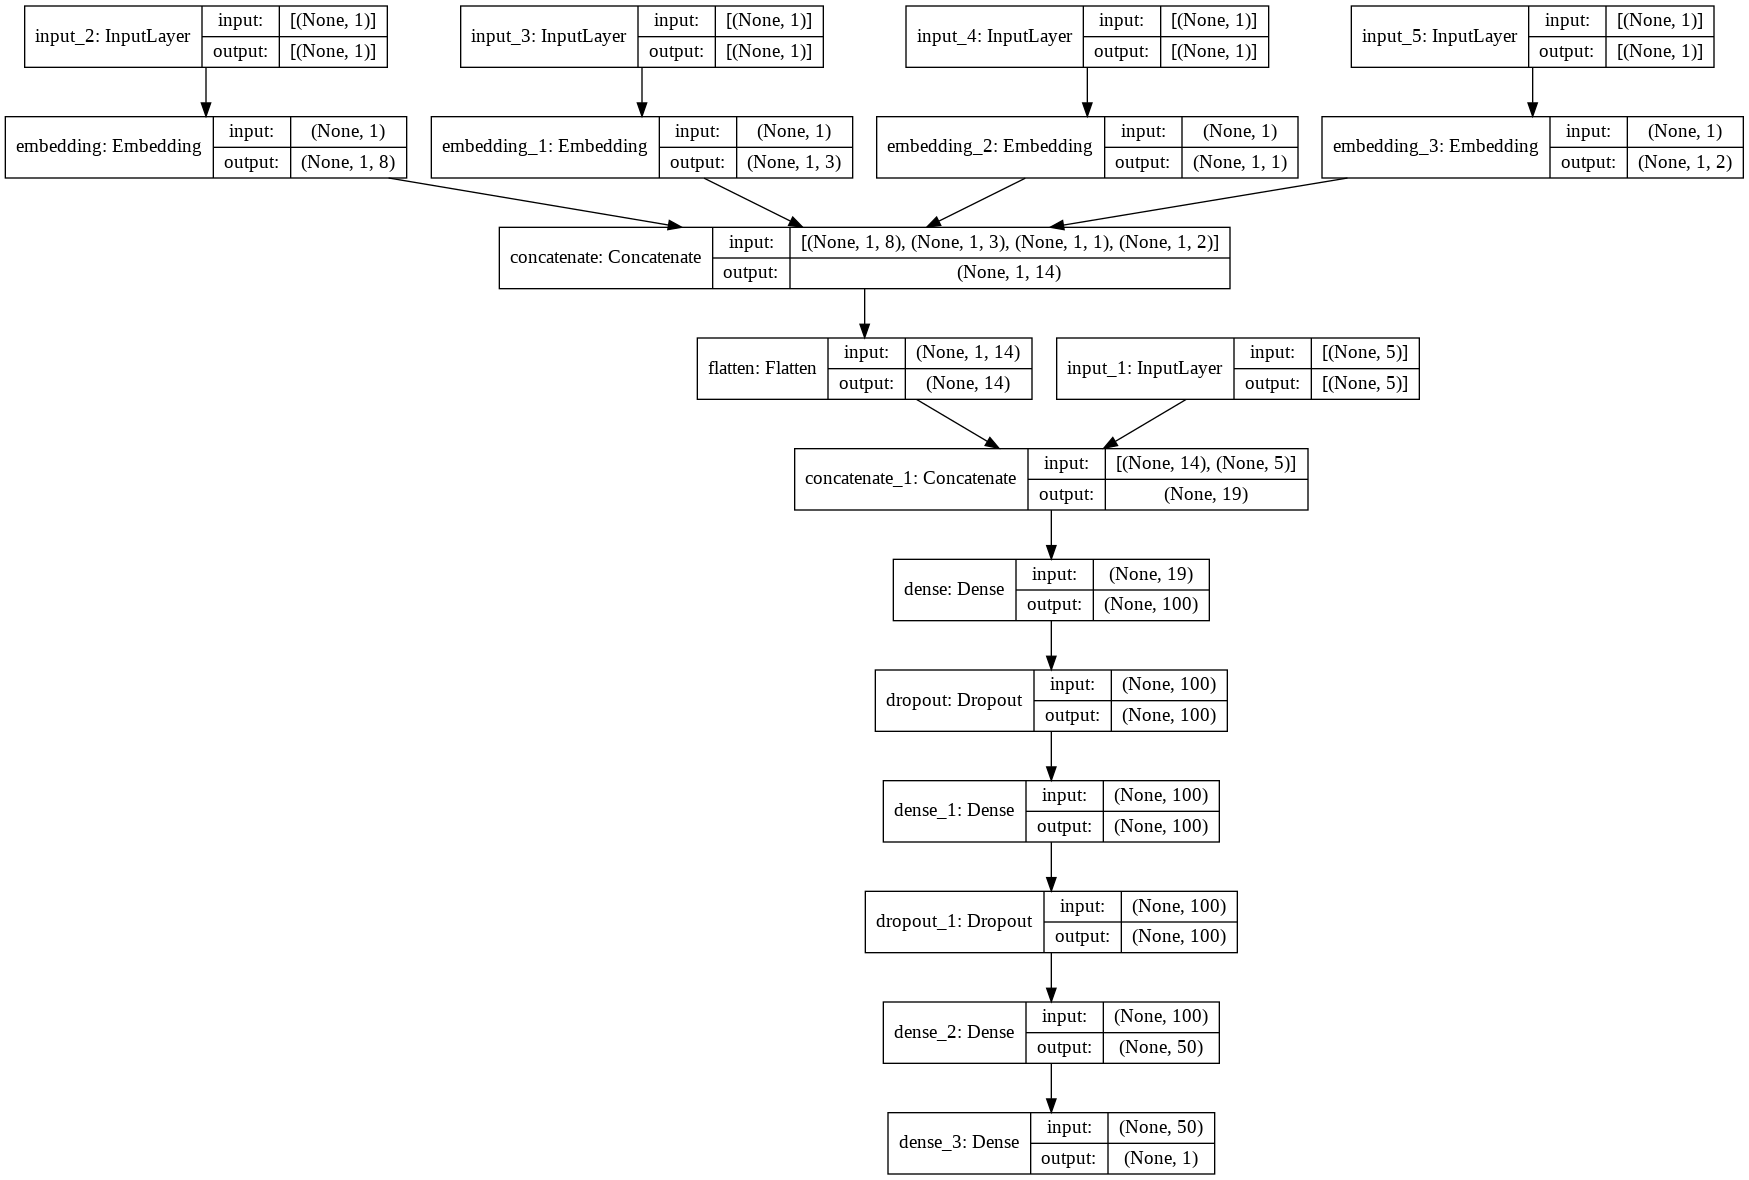

In [ ]:
keras.utils.plot_model(model, "categorical_embedding_model.png", show_shapes=True)

In [ ]:
EPOCHS = 500
BATCH_SIZE = 128

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True)


output_layer = model.layers[-1] 

model_history = model.fit(
    x=[X_train_col1, X_train_col2, X_train_col3, X_train_col4, X_train_num],
    y=y_train.values.reshape(-1,1),
    # These are not real epochs//number of samples/batch size = len(x_train_res)/2048
    steps_per_epoch=14,
    epochs=EPOCHS*10,
    callbacks=[early_stopping],
    validation_data=([X_val_col1, X_val_col2, X_val_col3, X_val_col4, X_val_num],y_val.values.reshape(-1,1)))


Epoch 1/5000
14/14 [==============================] - 2s 40ms/step - loss: 39718971528.5333 - mse: 39718971528.5333 - rmse: 199246.5365 - val_loss: 38128930816.0000 - val_mse: 38128930816.0000 - val_rmse: 195266.3125
Epoch 2/5000
14/14 [==============================] - 0s 8ms/step - loss: 36257434282.6667 - mse: 36257430186.6667 - rmse: 190379.4500 - val_loss: 32688488448.0000 - val_mse: 32688488448.0000 - val_rmse: 180799.5781
Epoch 3/5000
14/14 [==============================] - 0s 7ms/step - loss: 29188649506.1333 - mse: 29188649506.1333 - rmse: 170794.4875 - val_loss: 22056374272.0000 - val_mse: 22056374272.0000 - val_rmse: 148513.8906
Epoch 4/5000
14/14 [==============================] - 0s 8ms/step - loss: 21220222566.4000 - mse: 21220222566.4000 - rmse: 145254.3750 - val_loss: 9903482880.0000 - val_mse: 9903482880.0000 - val_rmse: 99516.2422
Epoch 5/5000
14/14 [==============================] - 0s 7ms/step - loss: 12540413815.4667 - mse: 12540413815.4667 - rmse: 108824.0781 - v

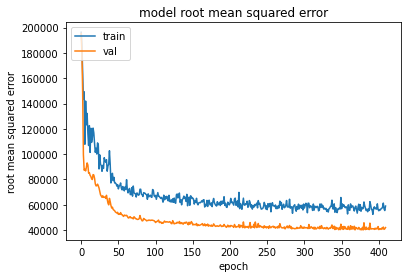

In [ ]:
%matplotlib inline

plt.plot(model_history.history['rmse'])
plt.plot(model_history.history['val_rmse'])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# The best score achieved by the model
best_score = min(model_history.history['val_rmse'])
best_score

40065.15625

In [ ]:
predicted_output = model.predict([X_test_col1, X_test_col2, X_test_col3, X_test_col4, X_test_num])

In [ ]:
predicted_output[1]

array([214051.55], dtype=float32)

In [ ]:
y_test_df = pd.DataFrame(y_test)

In [ ]:
y_test_df

,SalePrice
830,166000
948,192500
402,108000
1199,148000
1171,163000
...,...
1399,137450
292,131000
1386,250000
1240,224900


In [ ]:
data_predicted=pd.DataFrame(predicted_output.tolist(),columns=["Prediction"], index=y_test_df.index)
data_predicted

,Prediction
830,183583.796875
948,214051.546875
402,68973.742188
1199,179115.890625
1171,162796.015625
...,...
1399,141427.453125
292,161748.062500
1386,315137.437500
1240,214586.125000


In [ ]:
output = pd.concat([y_test_df,data_predicted],axis=1)

In [ ]:
output.columns=['ActualSalePrice', 'CEPredictedSalesPrice']
output.head()

,ActualSalePrice,CEPredictedSalesPrice
830,166000,183583.796875
948,192500,214051.546875
402,108000,68973.742188
1199,148000,179115.890625
1171,163000,162796.015625


# The One Hot Encoded Model

In [ ]:
for i in cat_features:
    print("Column name {} and unique values are {}".format(i,df[i].unique()))


Column name MSSubClass and unique values are [ 5  0  6  4 14  3 10 11  1  8 12  7 13  2  9]
Column name MSZoning and unique values are [3 4 0 1 2]
Column name Street and unique values are [1 0]
Column name LotShape and unique values are [3 0 1 2]


In [ ]:
for i in cat_features:
    print("Column name {} and unique values are {}".format(i,x_train[i].unique()))


Column name MSSubClass and unique values are [ 0 10  5  4 12 11  8  1  7  9  3  6 14  2 13]
Column name MSZoning and unique values are [3 4 1 0 2]
Column name Street and unique values are [1 0]
Column name LotShape and unique values are [0 3 1 2]


In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_cat)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [ ]:
X_train_cat

,MSSubClass,MSZoning,Street,LotShape
594,0,3,1,0
858,0,3,1,3
1008,0,3,1,0
897,10,3,1,3
257,0,3,1,3
...,...,...,...,...
115,12,1,1,3
635,14,2,1,3
194,0,3,1,0
79,4,4,1,3


In [ ]:
X_train_cat_arr = ohe.transform(X_train_cat).toarray()

In [ ]:
X_val_cat_arr = ohe.transform(X_val_cat).toarray()
X_test_cat_arr = ohe.transform(X_test_cat).toarray() 

In [ ]:
X_train_cat

,MSSubClass,MSZoning,Street,LotShape
594,0,3,1,0
858,0,3,1,3
1008,0,3,1,0
897,10,3,1,3
257,0,3,1,3
...,...,...,...,...
115,12,1,1,3
635,14,2,1,3
194,0,3,1,0
79,4,4,1,3


In [ ]:
len(X_train_cat_arr[1]) ## accounts for each category in binary

26

## The Model

In [ ]:
METRICS = [
      keras.metrics.MeanSquaredError(name='mse'),
      keras.metrics.RootMeanSquaredError(name='rmse')
]

# 5 numerical variables 
num_data = X_train_num
# 4 categorical variables with 26 levels in total
cat_data = X_train_cat_arr

# There is a different object for each categorical feature, each will be passed into its embedding layer
inp_num_data = keras.layers.Input(shape=(num_data.shape[1],))
inp_cat_data = keras.layers.Input(shape=(cat_data.shape[1],))

# Concatenate two layers
conc = keras.layers.Concatenate()([inp_cat_data, inp_num_data])
dense1 = keras.layers.Dense(100, activation=tf.nn.relu, )(conc)
dropout1 = keras.layers.Dropout(0.5) (dense1)
dense2 = keras.layers.Dense(100, activation=tf.nn.relu)(dropout1)
dropout2 = keras.layers.Dropout(0.5)(dense2)
dense3 = keras.layers.Dense(50, activation=tf.nn.relu)(dropout2)

# Creating output layer
out = keras.layers.Dense(1, activation=None)(dense3)
model1 = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)

model1.compile(loss=keras.losses.MeanSquaredError(), optimizer='adam', metrics=METRICS)

In [ ]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 31)           0           input_7[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          3200        concatenate_2[0][0]        

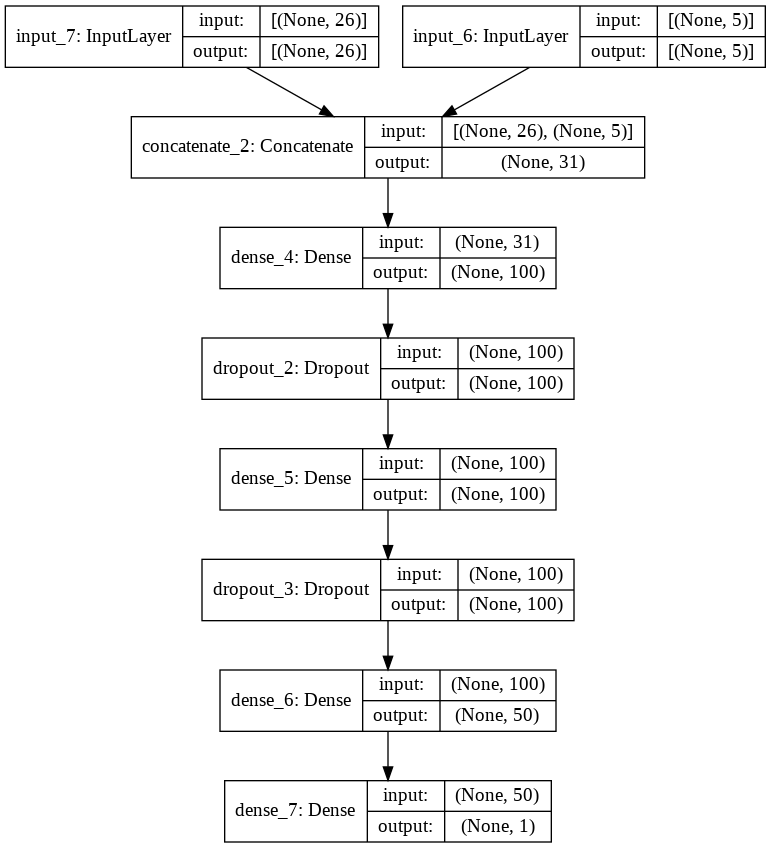

In [ ]:
keras.utils.plot_model(model1, "one_hot_encoder_model.png", show_shapes=True)


In [ ]:
EPOCHS = 500
BATCH_SIZE = 128

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse', 
    verbose=1,
    patience=30,
    mode='min',
    restore_best_weights=True)


output_layer = model1.layers[-1] 

model1_history = model1.fit(
    x=[X_train_cat_arr, X_train_num],
    y=y_train.values.reshape(-1,1),
    # These are not real epochs//number of samples/batch size = len(x_train_res)/2048
    steps_per_epoch=14,
    epochs=EPOCHS*10,
    callbacks=[early_stopping],
    validation_data=([X_val_cat_arr, X_val_num],y_val.values.reshape(-1,1)))


Epoch 1/5000
14/14 [==============================] - 1s 16ms/step - loss: 37117673335.4667 - mse: 37117673335.4667 - rmse: 192621.7833 - val_loss: 37440208896.0000 - val_mse: 37440208896.0000 - val_rmse: 193494.7188
Epoch 2/5000
14/14 [==============================] - 0s 5ms/step - loss: 34376272554.6667 - mse: 34376272554.6667 - rmse: 185375.8469 - val_loss: 29902579712.0000 - val_mse: 29902579712.0000 - val_rmse: 172923.6250
Epoch 3/5000
14/14 [==============================] - 0s 5ms/step - loss: 27919161207.4667 - mse: 27919161207.4667 - rmse: 166740.3677 - val_loss: 17850728448.0000 - val_mse: 17850728448.0000 - val_rmse: 133606.6250
Epoch 4/5000
14/14 [==============================] - 0s 5ms/step - loss: 16434888430.9333 - mse: 16434888430.9333 - rmse: 128043.7823 - val_loss: 8690532352.0000 - val_mse: 8690532352.0000 - val_rmse: 93223.0234
Epoch 5/5000
14/14 [==============================] - 0s 5ms/step - loss: 13890331716.2667 - mse: 13890331716.2667 - rmse: 117024.0677 - v

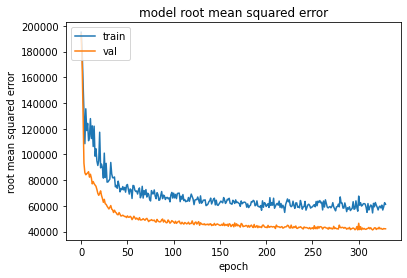

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(model1_history.history['rmse'])
plt.plot(model1_history.history['val_rmse'])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# The best score achieved by the model
best_score = min(model1_history.history['val_rmse'])
best_score

41278.83203125

In [ ]:
# The prediction
predicted_output = model1.predict([X_test_cat_arr, X_test_num])

In [ ]:
data_predictedOH=pd.DataFrame(predicted_output.tolist(),columns=["OHPrediction"], index=y_test_df.index)
data_predictedOH

,OHPrediction
830,176907.843750
948,206394.421875
402,67619.156250
1199,178343.953125
1171,159424.390625
...,...
1399,162065.890625
292,177607.625000
1386,311629.062500
1240,208339.640625


In [ ]:
output_final = pd.concat([output,data_predictedOH],axis=1)

In [ ]:
# Our Final Output
output_final.head()

,ActualSalePrice,CEPredictedSalesPrice,OHPrediction
830,166000,183583.796875,176907.843750
948,192500,214051.546875,206394.421875
402,108000,68973.742188,67619.156250
1199,148000,179115.890625,178343.953125
1171,163000,162796.015625,159424.390625


# Conclusion

Best Score for Categorical Embedding Model

In [ ]:
best_score = min(model_history.history['val_rmse'])
best_score

40065.15625

Best Score for OneHotEncoded model

In [ ]:
best_score = min(model1_history.history['val_rmse'])
best_score

41278.83203125

There is a slight advantage in this problem set, when using Categorical Embedding for categorical Variables. A slightly better score. 

In [ ]:
# Save models
model.save('CEModel.h5')
model1.save('OHModel.h5')